In [ ]:
import pandas as pd
from keras import Sequential
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support
)
import seaborn as sns
#from scikeras.wrappers import KerasClassifier, KerasRegressor
#import eli5
#from eli5.sklearn import PermutationImportance

In [4]:
# 1️⃣ Load dataset
df_train = pd.read_csv("data/features/session_based_trainset.csv")
print("Training dataset shape:", df_train.shape)
df_test = pd.read_csv("data/features/session_based_testset.csv")
print("Testing dataset shape:", df_test.shape)

Training dataset shape: (488524, 280)
Testing dataset shape: (122132, 280)


In [5]:
# 2️⃣ Use the correct label column
label_col = "label"
print("Unique values in label:", df_train[label_col].unique())
print("Unique values in label:", df_test[label_col].unique()) #is this flip-flop the source of a problem? Don't think so

Unique values in label: [0 1]
Unique values in label: [1 0]


In [6]:
# 3️⃣ Prepare features and target
y_raw = df_train[label_col]
X = df_train.drop(columns=[label_col]).fillna(0)

ytest_raw = df_test[label_col]
X_test = df_test.drop(columns=[label_col]).fillna(0) #new x test

In [7]:
# 4️⃣ Convert label text/numbers → binary
def map_label(val):
    val_str = str(val).lower()
    if "benign" in val_str or val == 0 or val == "0":
        return 0
    else:
        return 1

y = y_raw.apply(map_label)
y_test = ytest_raw.apply(map_label) #new y test
print("\nBinary label distribution in train set (0=Benign, 1=Malicious):\n", y.value_counts())
print("\nBinary label distribution in test set (0=Benign, 1=Malicious):\n", y_test.value_counts())


Binary label distribution in train set (0=Benign, 1=Malicious):
 label
1    245470
0    243054
Name: count, dtype: int64

Binary label distribution in test set (0=Benign, 1=Malicious):
 label
0    61273
1    60859
Name: count, dtype: int64


In [8]:
# 5️⃣ Train/test split
'''X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nX Train:", X_train.shape, "X Test:", X_test.shape)'''

#no need to perform splits since there is an entire separate testing data set
X_train = X
y_train = y
print(X_train.shape)

(488524, 279)


In [10]:
# 6️⃣ Train 1D CNN model
#this model with all these precise values here matches that of the paper to the letter, and probably won't work on other datasets bc of shape
"""cnn_model = Sequential()
cnn_model.add(layers.Conv1D(filters=50, kernel_size=5, strides=3, padding='valid', activation='relu', input_shape=(1480, 1)))
cnn_model.add(layers.Conv1D(filters=50, kernel_size=4, strides=3, padding='valid', activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=3, strides=3, padding='valid'))
cnn_model.add(layers.LSTM(units=50, return_sequences=True))
#may be a need for cropping here to get correct output size? idk
cnn_model.add(layers.Dense(units=500, activation='relu', dropout=0.5))
cnn_model.add(layers.Dense(units=50, activation='relu', dropout=0.5))
cnn_model.add(layers.Dense(units=12, activation='softmax'))"""
#this version is modified in terms of shape so that we can use it on the Mendley data set
cnn_model = Sequential()
cnn_model.add(layers.Conv1D(filters=64, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=(279, 1)))
cnn_model.add(layers.Conv1D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='valid'))
cnn_model.add(layers.LSTM(units=32, return_sequences=False))
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dropout(rate=0.5))
cnn_model.add(layers.Dense(units=32, activation='relu'))
cnn_model.add(layers.Dropout(rate=0.5))
cnn_model.add(layers.Dense(units=1, activation='sigmoid'))


cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32)

#my_model = KerasClassifier(build_fn=cnn_model)    
#my_model.fit(X_train,y_train)

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 134s 9ms/step - accuracy: 0.9119 - loss: 0.2159
Epoch 2/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - accuracy: 0.9721 - loss: 0.0770
Epoch 3/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 144s 9ms/step - accuracy: 0.9777 - loss: 0.0603
Epoch 4/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - accuracy: 0.9804 - loss: 0.0521
Epoch 5/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 139s 9ms/step - accuracy: 0.9818 - loss: 0.0498
Epoch 6/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 130s 9ms/step - accuracy: 0.9828 - loss: 0.0465
Epoch 7/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9841 - loss: 0.0430
Epoch 8/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - accuracy: 0.9849 - loss: 0.0411
Epoch 9/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - accuracy: 0.9855 - loss: 0.0391
Epoch 10/10
15267/15267 ━━━━━━━━━━━━━━━━━━━━ 132s 9ms/step - accuracy: 0.9859 - loss: 0.0382


In [18]:
# 7️⃣ Evaluate model
y_pred_proba = cnn_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {fscore}")
print(f"Support: {support}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", round(roc_auc_score(y_test, y_pred_proba), 4))

3817/3817 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9842 - loss: 0.0428
Test Loss: 0.0431
Test Accuracy: 0.9847
Precision: 0.9842562343013807
Recall: 0.9851295617739365
F1 Score: 0.9846927043983839
Support: None

Confusion Matrix:
[[60314   959]
 [  905 59954]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9852    0.9843    0.9848     61273
           1     0.9843    0.9851    0.9847     60859

    accuracy                         0.9847    122132
   macro avg     0.9847    0.9847    0.9847    122132
weighted avg     0.9847    0.9847    0.9847    122132

ROC AUC: 0.9989


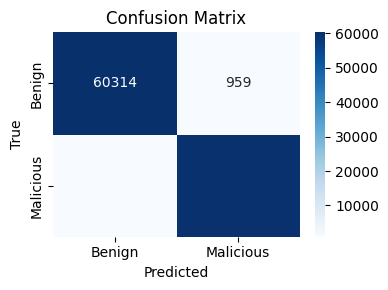

In [ ]:
# 8️⃣ Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
# 9️⃣ Feature Importance
#currently this seems to take forever to run, so I will maybe return to this
#perm = PermutationImportance(my_model, random_state=1).fit(X_train,y_train)
#eli5.show_weights(perm, feature_names = X_train.columns.tolist())

AttributeError: 'Sequential' object has no attribute 'feature_importances_'

In [20]:
# 🔟 Save 
cnn_model.save("report/clstm_session_model.keras")
print("\nModel saved in report/")


Model saved in report/
